In [1]:
import sys, os
sys.path.insert(0, '../')

import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from ase import Atoms
from ase.io import read
from ase.neighborlist import NeighborList

from cgf.cycles import find_cycles, cycle_graph
from cgf.motifs import find_unique_motifs
from cgf.utils import remove_hatoms
from cgf.bnff import _get_bonds, _get_phi0

from cgf.surrogate import (_find_linker_neighbor, _get_core_descriptors, _get_bond_descriptors, 
                        collect_descriptors, get_feature_matrix, _energy_internal, _num_internal_gradient, _internal_gradient)

In [2]:
# Tp Core Motif
motif = nx.Graph()
motif.add_edge("A", "B")
motif.add_edge("C", "B")
motif.add_edge("D", "B")

# all hexagons
motif.nodes['A']['cl'] = 6
motif.nodes['B']['cl'] = 6
motif.nodes['C']['cl'] = 6
motif.nodes['D']['cl'] = 6

# Descriptors from deformed unitcell

In [9]:
# the individual structures are stored in separate directories as json files

r0 = 30.082756/np.sqrt(3)

structures = []
energies = []
cells = []
bulk_or_shear = []
for fname in [f.path for f in os.scandir('../test-data/Triphenylene-DB_1phenyl/') if f.is_dir()]:
    s0 = read(fname + '/result.json')
    energies.append(s0.get_potential_energy())
    cells.append(s0.cell.array.copy())
    bulk_or_shear.append('bulk' in fname)
    remove_hatoms(s0)
    structures.append(s0)
    
energies = np.array(energies)

In [10]:
structures[0]

Atoms(symbols='C54B6O12', pbc=True, cell=[[30.08274028, 0.0, 0.0], [-15.04137013, 26.0524173, 0.0], [0.0, 0.0, 30.0]], calculator=SinglePointCalculator(...))

In [11]:
# find the cycles in the first structure
# it is assumed that the topology does not change and we can reuse this information
cy = find_cycles(structures[0])

G_cy = cycle_graph(cy, structures[0].positions)

# annotate cycles with cycle length
for n in G_cy.nodes:
    G_cy.nodes[n]['cl'] = len(G_cy.nodes[n]['cycle'])

mfs = find_unique_motifs(motif, G_cy)
print(len(mfs))


### this part is only needed for the plot in the next cell 
r_c = np.array([G_cy.nodes[m['B']]['pos'].mean(axis=0) for m in mfs]) # compute core centers
core_linker_dir = [[G_cy.nodes[m[ls]]['pos'].mean(axis=0)-G_cy.nodes[m['B']]['pos'].mean(axis=0) for ls in ['A', 'C', 'D']] for m in mfs]

cg_atoms = Atoms(['Y'] * len(r_c), positions=r_c, cell=s0.cell, pbc=True) # create coarse-grained representation based on core centers
cg_atoms.new_array('linker_sites', np.array(core_linker_dir)) # add positions of linker sites relative to core center

_find_linker_neighbor(cg_atoms, r0)
###


15
12
2


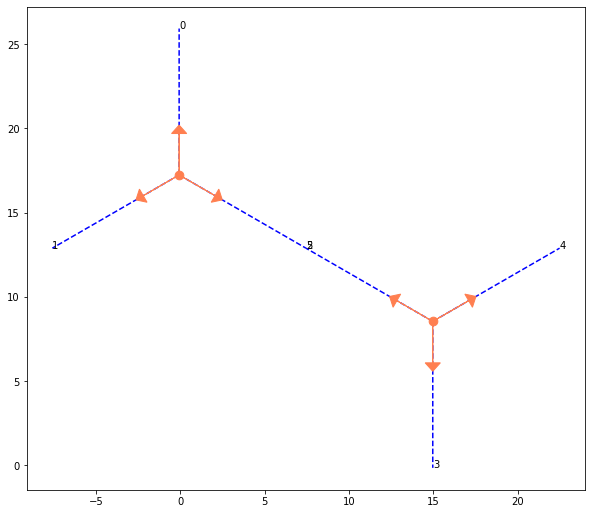

In [12]:
natoms = len(cg_atoms)
cell = cg_atoms.cell
positions = cg_atoms.positions
core_linker_dir = cg_atoms.get_array('linker_sites')
core_linker_neigh = cg_atoms.get_array('linker_neighbors')
bonds = _get_bonds(cg_atoms, r0)

nl = NeighborList( [1.2*r0/2] * natoms, self_interaction=False, bothways=True)
nl.update(cg_atoms)

fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, aspect='equal')

ax.scatter(positions[:,0],positions[:,1], color='coral', marker='o', s=75, zorder=10)
for i in range(core_linker_dir.shape[0]):
    for li in range(core_linker_dir.shape[1]):
        ax.arrow(positions[i,0],positions[i,1], core_linker_dir[i,li,0], core_linker_dir[i,li,1], color='coral', head_width=0.9, head_length=0.5, zorder=10)

for ib,b in enumerate(bonds):
    ii, nii, jj, njj = b[0], b[1], b[2], b[3]

    # get angle for site ii
    neighbors, offsets = nl.get_neighbors(ii)
    cells = np.dot(offsets, cell)
    distance_vectors = positions[neighbors] + cells - positions[ii]

    v2 = core_linker_dir[ii][core_linker_neigh[ii,nii]] # vector to linkage site
    v1 = distance_vectors[nii] # vector from ii to neighbor nii        
    
    ax.plot([positions[ii][0], positions[ii][0]+v1[0]/2], [positions[ii][1], positions[ii][1]+v1[1]/2], 'b--')
    ax.annotate(str(ib), [positions[ii][0]+v1[0]/2, positions[ii][1]+v1[1]/2])
        
plt.show()

In [13]:
core_descriptors, bond_descriptors = collect_descriptors(structures, cy, mfs, r0)

print('number of samples: %d' % (len(bond_descriptors)))
print('number of linkers: %d' % (len(bond_descriptors[0])))
print('number of descriptors per linker: %d' % (len(bond_descriptors[0][0])))
print('number of cores: %d' % (len(core_descriptors[0])))
print('number of descriptors per core: %d' % (len(core_descriptors[0][0])))

number of samples: 28
number of linkers: 6
number of descriptors per linker: 3
number of cores: 2
number of descriptors per core: 3


# Training using Ridge regression

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

In [15]:
# feature matrix
X = get_feature_matrix(core_descriptors, bond_descriptors)

# target values
y = energies-energies.min()

In [ ]:
# this somehow does not work as I expect, see below
reg = RidgeCV(alphas=[1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12]).fit(X, y)
reg.score(X, y)

0.953012479357179

In [ ]:
reg.alpha_

1e-12

In [ ]:
reg = Ridge(alpha=1e-11).fit(X, y)
reg.score(X, y)

0.9999832983255016

In [ ]:
mean_squared_error(reg.predict(X), y)

1.6577845673621878e-07

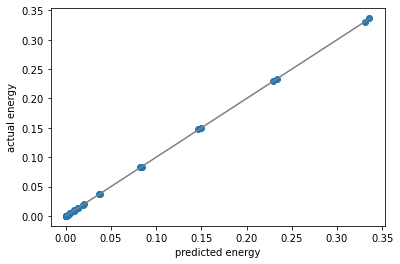

In [ ]:
plt.scatter(reg.predict(X), y)
plt.plot([0., y.max()], [0., y.max()], color='grey')
plt.xlabel('predicted energy')
plt.ylabel('actual energy')
plt.show()

In [ ]:
reg.coef_

array([-44.4342221 ,   1.27912546,   4.45880565,   4.45880571,
         4.4588041 ,  27.36968498])

In [ ]:
reg.intercept_

2315.3320266766013

# Prediction for defect structure

In [4]:
from cgf.cgatoms import write_cgatoms

In [3]:
s0 = read('../test-data/COF-5_opt_SW.gen', index=-1)
remove_hatoms(s0)

cy = find_cycles(s0)

G_cy = cycle_graph(cy, s0.positions)

for n in G_cy.nodes:
    G_cy.nodes[n]['cl'] = len(G_cy.nodes[n]['cycle'])
    
mfs = find_unique_motifs(motif, G_cy)
print(len(mfs))

148
108
18


In [5]:
# we could also use collect_descriptors but for plotting some additional stuff is needed

r0 = 30.082756/np.sqrt(3)

core_descriptors = []
bond_descriptors = []

G_cy = cycle_graph(cy, s0.positions)

r_c = np.array([G_cy.nodes[m['B']]['pos'].mean(axis=0) for m in mfs]) # compute core centers
core_linker_dir = [[G_cy.nodes[m[ls]]['pos'].mean(axis=0)-G_cy.nodes[m['B']]['pos'].mean(axis=0) for ls in ['A', 'C', 'D']] for m in mfs]

cg_atoms = Atoms(['Y'] * len(r_c), positions=r_c, cell=s0.cell, pbc=True) # create coarse-grained representation based on core centers
cg_atoms.new_array('linker_sites', np.array(core_linker_dir)) # add positions of linker sites relative to core center

_find_linker_neighbor(cg_atoms, r0)

#save_pickle(cg_atoms, '../test-data/COF-5_opt_SW_cg.pkl')
write_cgatoms(cg_atoms, '../test-data/COF-5_opt_SW_cg.json')

bonds = _get_bonds(cg_atoms, r0)
bond_desc = _get_bond_descriptors(cg_atoms, r0, bonds)
bond_descriptors.append(bond_desc)

core_desc = _get_core_descriptors(cg_atoms, r0)
core_descriptors.append(core_desc)    

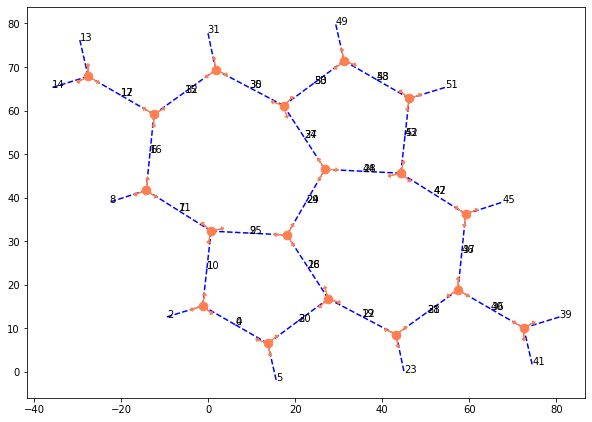

In [6]:
natoms = len(cg_atoms)
cell = cg_atoms.cell
positions = cg_atoms.positions
core_linker_dir = cg_atoms.get_array('linker_sites')
core_linker_neigh = cg_atoms.get_array('linker_neighbors')

nl = NeighborList( [1.2*r0/2] * natoms, self_interaction=False, bothways=True)
nl.update(cg_atoms)

fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, aspect='equal')

ax.scatter(positions[:,0],positions[:,1], color='coral', marker='o', s=75, zorder=10)
for i in range(core_linker_dir.shape[0]):
    for li in range(core_linker_dir.shape[1]):
        ax.arrow(positions[i,0],positions[i,1], core_linker_dir[i,li,0], core_linker_dir[i,li,1], color='coral', head_width=0.9, head_length=0.5, zorder=10)

for ib,b in enumerate(bonds):
    ii, nii, jj, njj = b[0], b[1], b[2], b[3]

    # get angle for site ii
    neighbors, offsets = nl.get_neighbors(ii)
    cells = np.dot(offsets, cell)
    distance_vectors = positions[neighbors] + cells - positions[ii]

    v2 = core_linker_dir[ii][core_linker_neigh[ii,nii]] # vector to linkage site
    v1 = distance_vectors[nii] # vector from ii to neighbor nii        
    
    ax.plot([positions[ii][0], positions[ii][0]+v1[0]/2], [positions[ii][1], positions[ii][1]+v1[1]/2], 'b--')
    ax.annotate(str(ib), [positions[ii][0]+v1[0]/2, positions[ii][1]+v1[1]/2])
        
plt.show()

In [7]:
# feature matrix
X = get_feature_matrix(core_descriptors, bond_descriptors)

print('number of samples: %d' % (len(bond_descriptors)))
print('number of linkers: %d' % (len(bond_descriptors[0])))
print('number of descriptors per linker: %d' % (len(bond_descriptors[0][0])))
print('number of cores: %d' % (len(core_descriptors[0])))
print('number of descriptors per core: %d' % (len(core_descriptors[0][0])))

number of samples: 1
number of linkers: 54
number of descriptors per linker: 3
number of cores: 18
number of descriptors per core: 3


In [ ]:
reg.intercept_ = reg.intercept_ * 54/6 # we have to adjust the intercept for the different number of linkers!

In [ ]:
# final energy
reg.predict(X)

array([12.75394916])

In [ ]:
np.dot(reg.coef_, X.reshape(-1)) + reg.intercept_

12.75394916022924

# Calculator

In [8]:
from cgf.surrogate_ref import MikadoRR

In [9]:
calc = MikadoRR(r0=30.082756/np.sqrt(3), rr_coeff=np.array([-44.4342221, 1.27912546, 4.45880587, 4.45880586,
         4.45880373, 27.369685]), rr_incpt=2315.3320266790165/6, opt=False)

In [10]:
cg_atoms.calc = calc

In [11]:
cg_atoms.get_potential_energy()

12.753976338633947

In [ ]:
ana_forces = cg_atoms.get_forces()
ana_forces

array([[-1.98963313e-01,  4.54656629e-01,  3.14966108e-06],
       [ 4.91973482e-01,  5.73868113e-02,  2.84772887e-06],
       [-2.98146972e-01, -4.07764430e-02,  2.36940983e-07],
       [-5.46192726e-01,  3.10203528e-01, -4.13460524e-07],
       [ 7.01851984e-01, -4.08979914e-01, -3.38357321e-06],
       [ 3.37198901e-02, -1.85873727e-02, -1.69800862e-06],
       [ 5.44608041e-01, -3.21909429e-01,  5.53481600e-07],
       [ 1.12947155e-01, -2.78699166e-01, -4.65993317e-07],
       [ 3.48910534e-01,  6.11996161e-01, -2.60438993e-07],
       [-3.48752627e-01, -6.12350214e-01, -1.50194665e-07],
       [-1.12964836e-01,  2.78699102e-01, -2.37471211e-07],
       [-5.44567788e-01,  3.22331923e-01,  2.16218943e-07],
       [-3.38780142e-02,  1.85654409e-02, -2.08992156e-06],
       [-7.01774738e-01,  4.08932902e-01, -4.14160766e-06],
       [ 5.46292514e-01, -3.10413894e-01, -2.56564860e-07],
       [ 2.98062162e-01,  4.10140343e-02,  1.44003047e-07],
       [-4.92083276e-01, -5.72986514e-02

In [ ]:
num_forces = calc.calculate_numerical_forces(cg_atoms)
num_forces

array([[-1.98963278e-01,  4.54656540e-01,  3.14685167e-06],
       [ 4.91973527e-01,  5.73869129e-02,  2.84853741e-06],
       [-2.98146939e-01, -4.07765310e-02,  2.38287612e-07],
       [-5.46192781e-01,  3.10203570e-01, -4.12910595e-07],
       [ 7.01851972e-01, -4.08979991e-01, -3.38695827e-06],
       [ 3.37198835e-02, -1.85872759e-02, -1.69711711e-06],
       [ 5.44607978e-01, -3.21909498e-01,  5.49334800e-07],
       [ 1.12947191e-01, -2.78699075e-01, -4.67480277e-07],
       [ 3.48910638e-01,  6.11996164e-01, -2.58296495e-07],
       [-3.48752728e-01, -6.12350223e-01, -1.50976120e-07],
       [-1.12964875e-01,  2.78699006e-01, -2.38287612e-07],
       [-5.44567723e-01,  3.22331993e-01,  2.11002771e-07],
       [-3.38780046e-02,  1.85653389e-02, -2.09001882e-06],
       [-7.01774727e-01,  4.08932978e-01, -4.14729584e-06],
       [ 5.46292564e-01, -3.10413940e-01, -2.60115485e-07],
       [ 2.98062125e-01,  4.10141238e-02,  1.47338142e-07],
       [-4.92083314e-01, -5.72987537e-02

In [ ]:
ana_forces - num_forces

array([[-3.48841874e-08,  8.88626309e-08,  2.80941326e-09],
       [-4.54937392e-08, -1.01573442e-07, -8.08531748e-10],
       [-3.31698506e-08,  8.80439857e-08, -1.34662929e-09],
       [ 5.54407178e-08, -4.20941030e-08, -5.49929416e-10],
       [ 1.25762789e-08,  7.76030963e-08,  3.38505875e-09],
       [ 6.58171594e-09, -9.68038942e-08, -8.91507958e-10],
       [ 6.32807300e-08,  6.88787835e-08,  4.14679987e-09],
       [-3.59233432e-08, -9.07285146e-08,  1.48695974e-09],
       [-1.04648501e-07, -2.84614232e-09, -2.14249776e-09],
       [ 1.01304572e-07,  8.16165224e-09,  7.81455636e-10],
       [ 3.88965385e-08,  9.60697111e-08,  8.16400656e-10],
       [-6.47558158e-08, -6.99530666e-08,  5.21617175e-09],
       [-9.60073567e-09,  1.01986006e-07,  9.72669442e-11],
       [-1.18695811e-08, -7.62165555e-08,  5.68817712e-09],
       [-4.94359755e-08,  4.55770264e-08,  3.55062483e-09],
       [ 3.67233855e-08, -8.95243705e-08, -3.33509501e-09],
       [ 3.87093690e-08,  1.02378551e-07

In [ ]:
p0 = cg_atoms.get_array('linker_sites')
_energy_internal(p0.reshape(-1), cg_atoms, calc.parameters.r0, calc.parameters.rr_coeff, calc.parameters.rr_incpt)

12.753976338633947

In [ ]:
int_gradient = _internal_gradient(p0.reshape(-1), cg_atoms, calc.parameters.r0, calc.parameters.rr_coeff, calc.parameters.rr_incpt)

In [ ]:
import itertools

num_int_grad = [[_num_internal_gradient(cg_atoms, at, li, i, calc.parameters.r0, calc.parameters.rr_coeff, calc.parameters.rr_incpt) for i in range(3)] for (at,li) in itertools.product(range(natoms), range(3))]

np.array(num_int_grad) - int_gradient.reshape((54,3))

array([[ 7.04322508e-07,  2.72414421e-06,  2.20497096e-09],
       [-1.47725957e-06, -2.10186088e-07,  6.56790345e-10],
       [-3.10275915e-06,  2.78903452e-06,  5.04354770e-10],
       [-2.58779024e-06, -3.31509484e-06, -3.36643216e-10],
       [-1.34715171e-06,  4.06340691e-07,  6.27115322e-10],
       [ 7.42371397e-07, -3.16691012e-06,  1.23375815e-10],
       [ 1.00314893e-06,  2.61221812e-06, -9.17312765e-10],
       [-8.09609920e-07, -1.48938379e-07, -5.53663133e-10],
       [-2.03807872e-06,  3.33789354e-06,  3.78234206e-10],
       [-4.52706058e-07, -1.24504152e-06,  1.86900454e-09],
       [ 1.72476846e-06,  4.68848731e-07, -1.50443254e-09],
       [ 2.76814245e-06, -3.01896382e-06,  6.80522333e-10],
       [ 1.87855134e-06,  2.86755194e-06, -1.65832949e-09],
       [ 4.71541748e-07,  2.42526303e-09, -3.41015247e-10],
       [-1.87311937e-06,  3.23952036e-06,  2.20939800e-10],
       [-1.81562716e-06, -3.34685095e-06, -5.93151278e-10],
       [ 3.09867252e-07,  5.39039228e-10

In [ ]:
calc = MikadoRR(r0=30.082756/np.sqrt(3), rr_coeff=np.array([-44.4342221, 1.27912546, 4.45880587, 4.45880586,
         4.45880373, 27.369685]), rr_incpt=2315.3320266790165/6, opt=True)

cg_atoms.calc = calc

cg_atoms.get_potential_energy()

12.753976338633947

### Compare MikadoRR versions

In [12]:
from cgf.surrogate_ref import MikadoRR
from cgf.surrogate import MikadoRR as MikadoRR_V2

from cgf.cgatoms import read_cgatoms

In [13]:
cg_atoms_V1 = read_cgatoms('../test-data/COF-5_opt_SW_cg.json')

In [14]:
#%%timeit
calc = MikadoRR(r0=30.082756/np.sqrt(3), rr_coeff=np.array([-44.4342221, 1.27912546, 4.45880587, 4.45880586,
         4.45880373, 27.369685]), rr_incpt=2315.3320266790165/6)

cg_atoms_V1.calc = calc
cg_atoms_V1.get_potential_energy()
ana_forces = cg_atoms_V1.get_forces()


Optimization terminated successfully.
         Current function value: 11.982403
         Iterations: 7
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 11.982403
         Iterations: 7
         Function evaluations: 15
         Gradient evaluations: 15


In [15]:
cg_atoms_V2 = read_cgatoms('../test-data/COF-5_opt_SW_cg.json')

In [16]:
#%%timeit
calc = MikadoRR_V2(r0=30.082756/np.sqrt(3), rr_coeff=np.array([-44.4342221, 1.27912546, 4.45880587, 4.45880586,
         4.45880373, 27.369685]), rr_incpt=2315.3320266790165/6)

cg_atoms_V2.calc = calc
cg_atoms_V2.get_potential_energy()
ana_forces = cg_atoms_V2.get_forces()

Optimization terminated successfully.
         Current function value: 11.982403
         Iterations: 7
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 11.982403
         Iterations: 7
         Function evaluations: 15
         Gradient evaluations: 15


In [17]:
cg_atoms_V1.get_potential_energy() - cg_atoms_V2.get_potential_energy()

0.0

In [18]:
cg_atoms_V1.get_forces() - cg_atoms_V2.get_forces()

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])